In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

## Representative images

## Read images

In [121]:
exp="calret"
#exp2="maxproj"


results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ECM spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("posthoc" in str(filelist[i]))==False:
                #if (exp in str(filelist[i][-40:]))==True:
                if (exp in str(filelist[i]))==True:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

In [122]:
len(results["filename"])

90

## Show all images

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268089)
ImageJ ser

UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190704_tnr550_blkplus12_calreticulincy2_zstacks_analyse/maxprojections/20190704_tnr550_blkplus12_calreticulincy2_zstacks_Series9_z0_ch1_t0.tif'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190704_tnr550_blkplus12_calreticulincy2_zstacks_analyse/maxprojections/20190704_tnr550_blkplus12_calreticulincy2_zstacks_Series9_z0_ch1_t0.tif'
<class 'pims.bioformats.BioformatsReader'> errored: The file "/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190704_tnr550_blkplus12_calreticulincy2_zstacks_analyse/maxprojections/20190704_tnr550_blkplus12_calreticulincy2_zstacks_Series9_z0_ch1_t0.tif" does not exist.


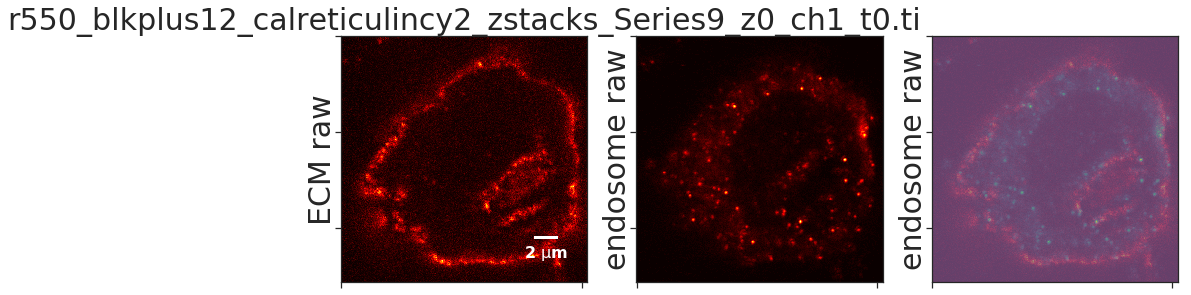

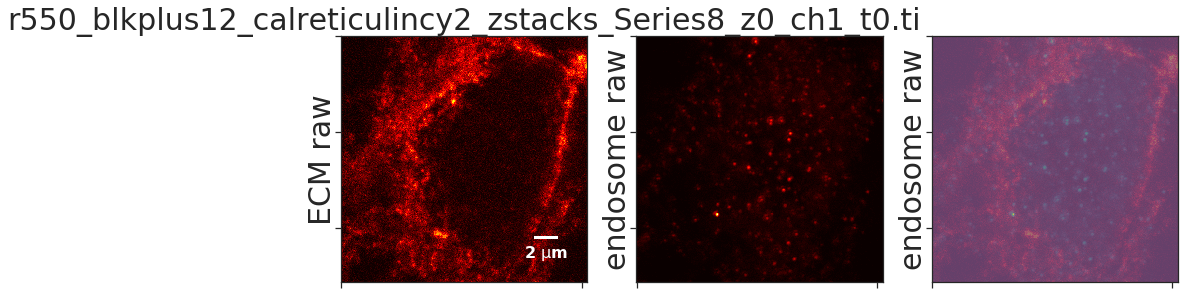

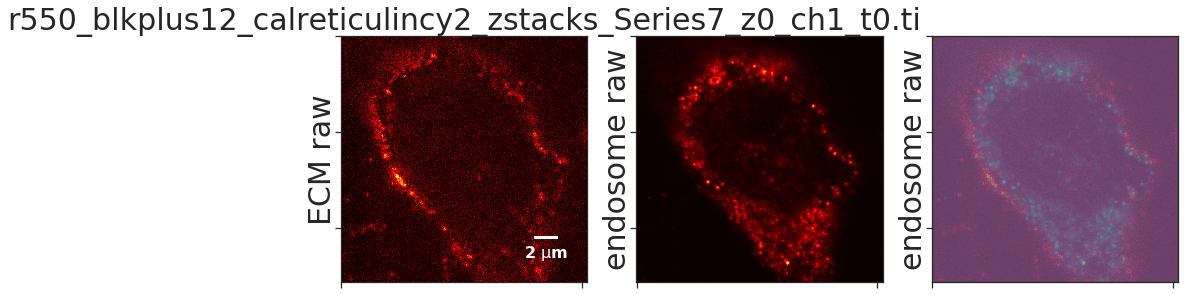

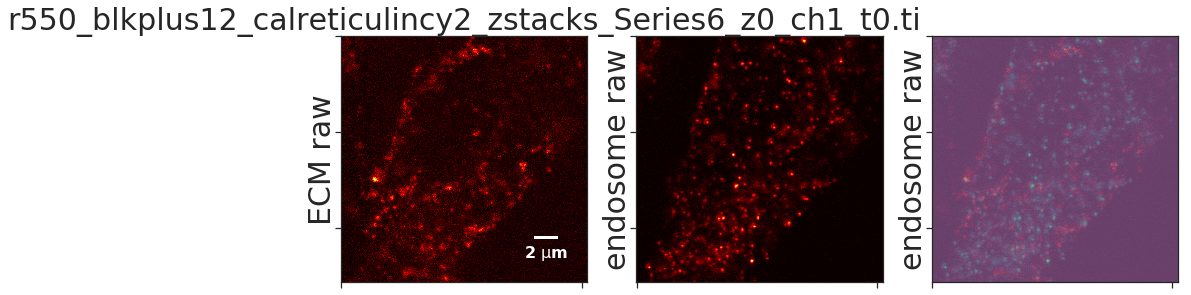

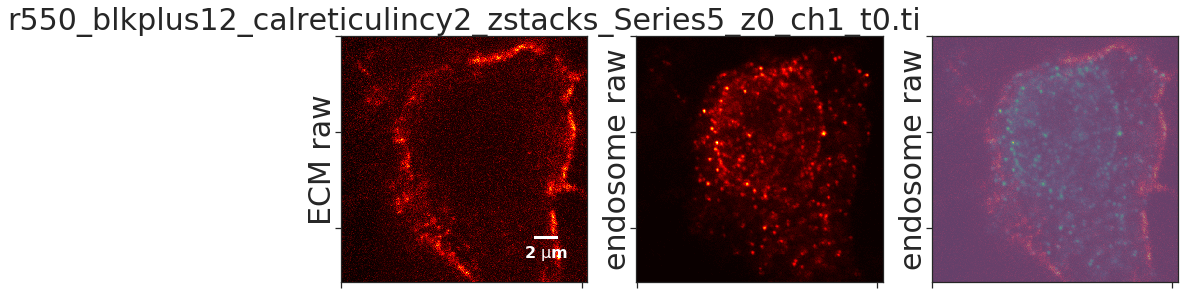

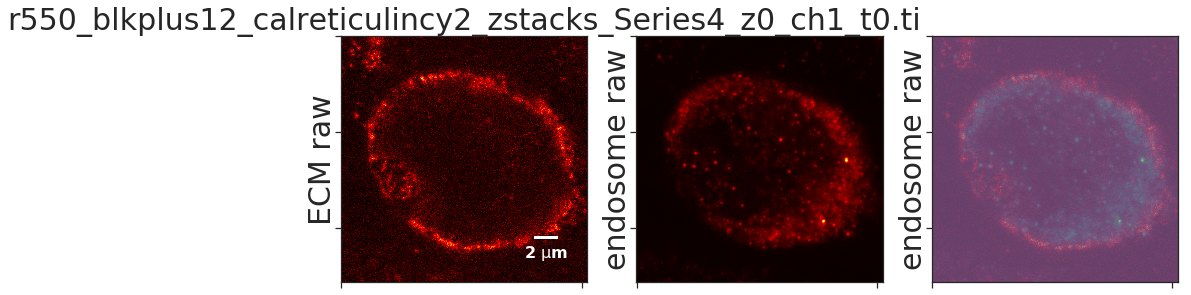

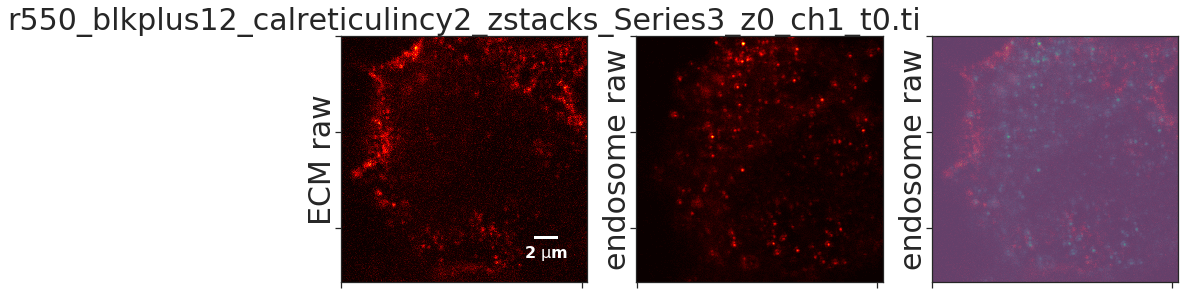

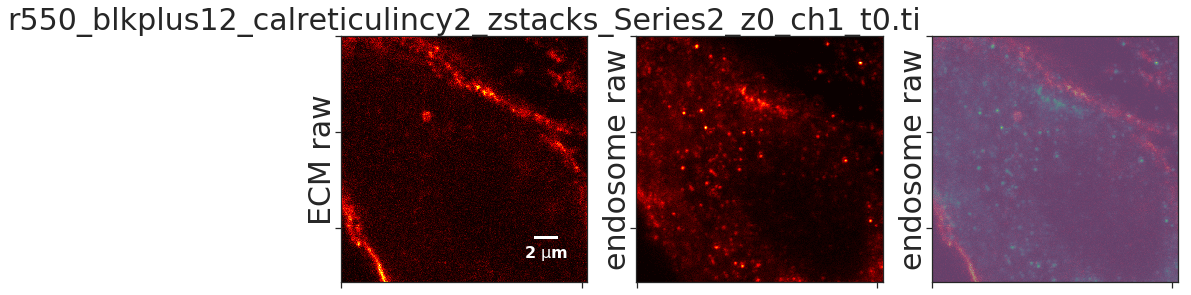

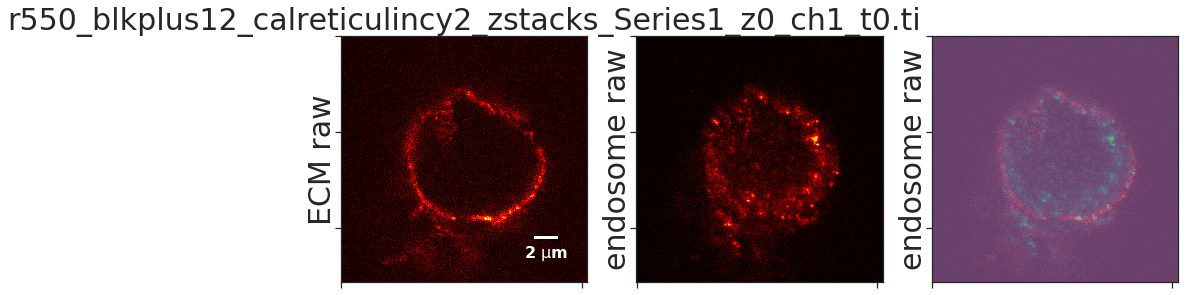

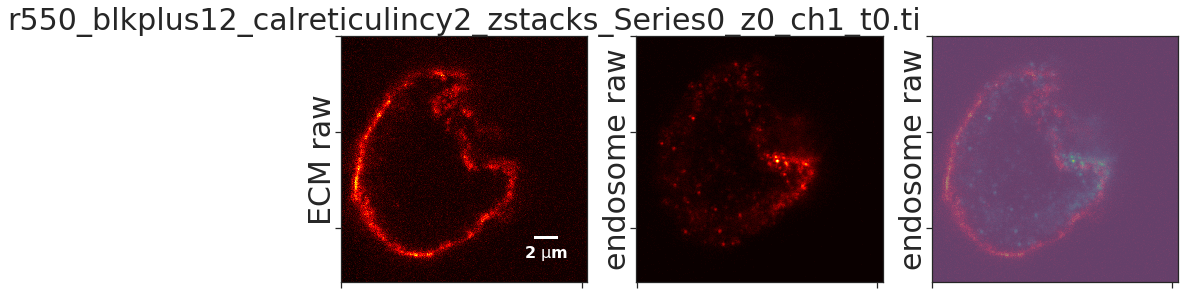

In [123]:
for image in range(0,len(results["filename"])):
    ecm_channel_no=results["ecmchannelno"][image]
    endosome_channel_no=results["endosomechannelno"][image]
    
    ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    
    #print("Image name:",results["filename"][image].split('/')[-1])
    #print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    
    figure=plt.figure(figsize=(15,15))
    figure.add_subplot(131)
    plt.imshow(ecm_image,interpolation='none',cmap='hot')
    plt.title(ecm_image_name[-60:-1])
    plt.ylabel('ECM raw')
    plt.grid(visible=False)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                           font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    

    figure.add_subplot(132)
    plt.imshow(endosome_image,interpolation='none',cmap='hot')
    
    plt.ylabel('endosome raw')
    plt.grid(visible=False)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                           font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter

    #plt.gca().add_artist(scalebar)
    
    figure.add_subplot(133)
    plt.imshow(ecm_image,interpolation='none',cmap='hot',alpha=.5)
    plt.imshow(endosome_image,interpolation='none',cmap='viridis',alpha=.5)
    plt.ylabel('endosome raw')
    plt.grid(visible=False)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                           font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter

    #plt.gca().add_artist(scalebar)

## Read analyses from Silvio

In [30]:
organelledf=pd.read_csv(filepath_or_buffer=expdir+'Organelle_coloc_analysis/201908_Coloc_linescan_calculationsfromSilvio_Organelles.csv',
                       sep=';')

## Make dataframe

In [31]:
organelledf

,Protein,expnumber,corrected perc
0,"TGN38/ TNR Blk, +12",1,3.7887
1,"TGN38/ TNR Blk, +12",2,5.8955
2,"TGN38/ TNR Blk, +12",3,3.1483
3,"TGN38/ TNR Blk, +12",4,0.9819
4,"Rab11a/ TNR Blk, +12",1,2.0660
5,"Rab11a/ TNR Blk, +12",2,1.9834
6,"Rab11a/ TNR Blk, +12",3,0.8586
7,"Rab11a/ TNR Blk, +12",4,1.1301
8,Cav1/ TNR Blk,1,0.5997
9,Cav1/ TNR Blk,2,0.3061


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

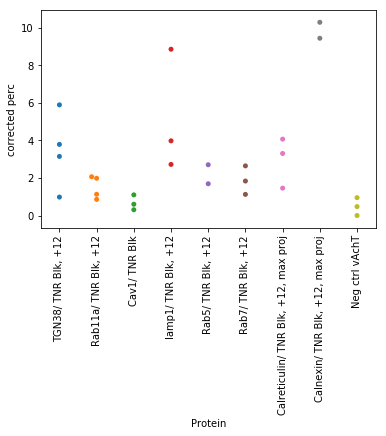

In [35]:
sns.swarmplot(data=organelledf,x="Protein",y="corrected perc")
plt.xticks(rotation=90)

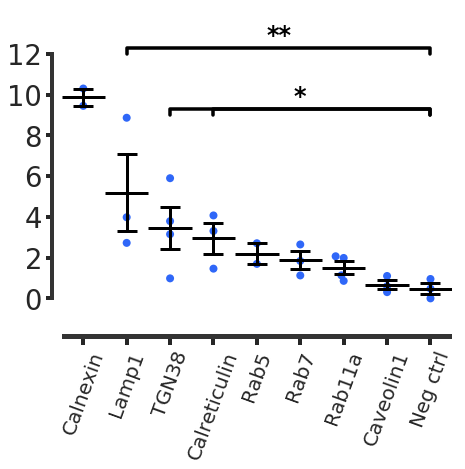

In [109]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

df2plot=organelledf
var="corrected perc"
#var="ecm mean int norm2med"
fig=plt.figure(figsize=(7,6))

order=['Calnexin/ TNR Blk, +12, max proj','lamp1/ TNR Blk, +12','TGN38/ TNR Blk, +12'
       ,'Calreticulin/ TNR Blk, +12, max proj',
       'Rab5/ TNR Blk, +12',
      'Rab7/ TNR Blk, +12','Rab11a/ TNR Blk, +12','Cav1/ TNR Blk','Neg ctrl vAchT']

#g=sns.barplot(data=df2plot,y=var,x="Protein"
#            ,order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Protein",color="#2F67F8",order=order,size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        #change edgecolor
        #clr = patch.get_facecolor()
        #if clr==(1.0, 1.0, 1.0, 0.3):
         #   patch.set_edgecolor('#777777')
          #  patch.set_alpha(1)
        #patch.set_edgewidth(3)
        #patch.set_linewidth(10)
        #patch.set_linewidth(4)
        

change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][var].mean() for condtype in order],
             yerr=None,
             xerr=np.repeat(0.5, 9),ecolor='black',fmt='none',capsize=0,linewidth=3,
             capthick=30,zorder=10,
            alpha=1)


plt.axhline(-2, color='#333333',alpha=1,linewidth=10)



#plt.yticks([0,.1,.2,.3],color='#333333')
#plt.xticks(g.get_xticks(),['2h','4h','12h','No Blocking'],color='#333333',size=20)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)


#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'


#g.set_ylabel('Normalised \nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Calnexin','Lamp1','TGN38','Calreticulin','Rab5',
      'Rab7','Rab11a','Caveolin1','Neg ctrl'],
           rotation=70,size=20)
plt.yticks([0,2,4,6,8,10,12],size=24,color='#333333')
g.grid(False)
plt.ylim([-2,14])


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)



x1, x2 = 1,8
y= 12
h=0.3
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,8
y= 9
h=0.3
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 3,8
y= 9
h=0.3
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "", ha='center', va='bottom', color=col,size=24, weight='bold')



diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'3b_confocal_colocs.svg', bbox_inches='tight', format='svg')










<Figure size 432x288 with 0 Axes>

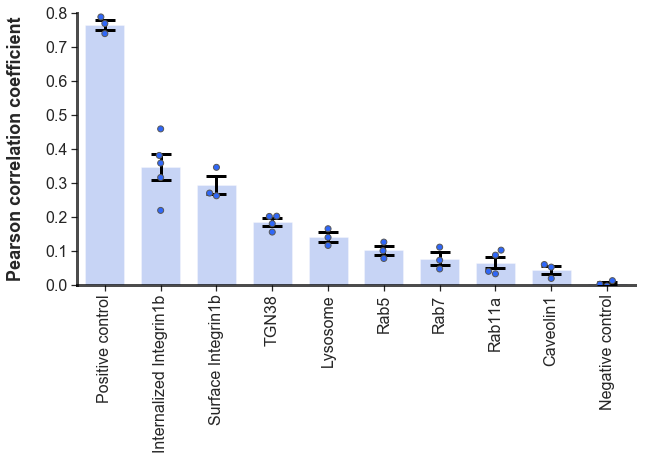

In [7]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")

order=['Pos ctrl 2 secondaries','Int1b, all TNR Blk+12, stripped','Int1b Blk/TNR Blk, +0, surface',
       'TGN38/ TNR Blk, +12','lamp1/ TNR Blk, +12','Rab5/ TNR Blk, +12',
      'Rab7/ TNR Blk, +12','Rab11a/ TNR Blk, +12','Cav1/ TNR Blk','Neg ctrl vAchT']
names=['Positive control','Internalized Integrin1b','Surface Integrin1b','TGN38','Lysosome','Rab5','Rab7',
      'Rab11a','Caveolin1','Negative control']

var="mean correlation"
fig=plt.figure(figsize=(10,5))
#order=['2hrs','4hrs','12hrs','No Blocking']
#palette ={"No Blocking":"gray","2hrs":"magenta","4hrs":"magenta","12hrs":"magenta"}

g=sns.swarmplot(x="Protein",y=var,
                data=newdf,size=6,color="#2F67F8",linewidth=1,order=order)

g=sns.barplot(x="Protein",y=var,
                data=newdf,alpha=0.3,ci=None,color="#2F67F8",order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .7)

plt.errorbar(x=np.arange(0,len(order)),
             y=[newdf[newdf["Protein"]==protein][var].mean() for protein in order],
             yerr=[newdf[newdf["Protein"]==protein][var].sem() for protein in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3)


#scale_y=1/100
#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
#g.yaxis.set_major_formatter(ticks_y)
g.set_ylabel('Pearson correlation coefficient',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',size=14,weight ='bold',labelpad=20)
plt.xticks(g.get_xticks(),names,size=16,rotation=90)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)
plt.ylim([0,0.8])

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'organellecoloc.svg', bbox_inches='tight', format='svg')


#plt.ylim([-0.1,0.7])

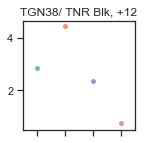

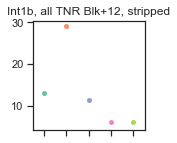

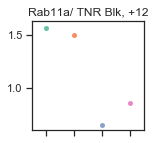

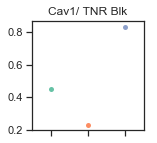

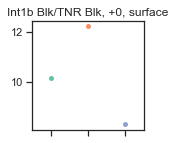

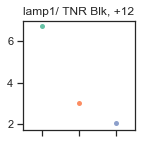

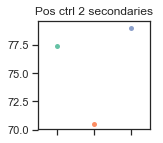

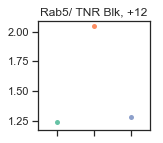

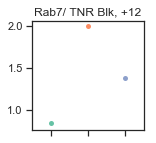

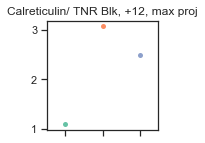

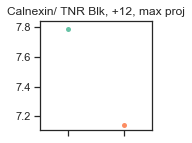

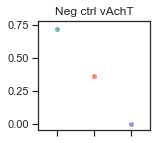

In [13]:
results_allprot={"Protein":[],"expnumber":[],"perc_over":[]}
for protein in newdf["Protein"].unique():
    dfprot=newdf[newdf["Protein"]==protein]
    dfprot=dfprot.reset_index()
    percentages=[]
    expi=[]
    count=1
    for exp in dfprot["exp condition"].unique():
        dfexp=dfprot[dfprot["exp condition"]==exp]
        a=np.sum(dfexp["correlation"].values[0]>0.7)/len(dfexp["correlation"].values[0])*100
        percentages.append(a)
        expi.append(exp)
        results_allprot["Protein"].append(protein)
        results_allprot["expnumber"].append(count)
        results_allprot["perc_over"].append(a)
        count+=1
    plt.figure(figsize=(2,2))
    g=sns.swarmplot(x=expi,y=percentages)
    plt.title(protein)
    plt.xticks(g.get_xticks(),'')
    

In [245]:
df_all=pd.DataFrame(results_allprot)

In [248]:
df_all.to_csv("/Volumes/Macintosh HD/Users/taldankovich/Downloads/allvals.csv'",sep=';')